In [1]:
# Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

### Analisis inicial

In [2]:
pronostico = pd.read_csv("weatherAUS.csv")

In [3]:
pronostico.info() # 145460

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

1- Date: La fecha en la que se registró.

2- Location: La ciudad en Australia.

3- MinTemp: Temperatura mínima registrada ese día (en grados).

4- MaxTemp: Temperatura máxima registrada ese día (en grados).

5- Rainfall: Cantidad de lluvia registrada ese día (en mm).

6- Evaporation: Cantidad de agua evaporada ese día (en mm).

7- Sunshine: Número de horas de sol.

8- WindGustDir: Dirección del viento durante la ráfaga más fuerte.

9- WindGustSpeed: Velocidad de la ráfaga de viento más fuerte (en km/h).

10- WindDir9am: Dirección del viento a las 9 de la mañana.

11- WindDir3pm: Dirección del viento a las 3 de la tarde.

12- WindSpeed9am: Velocidad del viento a las 9 de la mañana (en km/h).

13- WindSpeed3pm: Velocidad del viento a las 3 de la tarde (en km/h).

14- Humidity9am: Porcentaje de humedad relativa a las 9 de la mañana (en %).

15- Humidity3pm: Porcentaje de humedad relativa a las 3 de la tarde (en %).

16- Pressure9am: Presión atmosférica a las 9 de la mañana (en hPa).

17- Pressure3pm: Presión atmosférica a las 3 de la tarde (en hPa).

18- Cloud9am: Cobertura de nubes a las 9 de la mañana (en oktas, de 0 a 8).

19- Cloud3pm: Cobertura de nubes a las 3 de la tarde (en oktas, de 0 a 8).

20- Temp9am: Temperatura a las 9 de la mañana (en grados).

21- Temp3pm: Temperatura a las 3 de la tarde (en grados).

22- RainToday: Indica si llovió hoy.

23- RainTomorrow: Variable objetivo que indica si lloverá al día siguiente.

In [4]:
pronostico["Date"] = pd.to_datetime(pronostico["Date"])

### Creacion de columnas nuevas

#### Creacion de columnas de tiempo y categoricas como estacion del año y simplificación de la direccion del viento

In [5]:
# Creamos variables de fecha, para poder mejorar el modelo.

pronostico["dia"] = pronostico["Date"].dt.day
pronostico["mes"] = pronostico["Date"].dt.month
pronostico["año"] = pronostico["Date"].dt.year

In [6]:
def categorizar_rainfall(mm):
    """
    Categorizamos la cantidad de lluvia en mm en diferentes niveles.
    Args:
        mm (float): Cantidad de lluvia en mm.
    Returns:
        str: Categoría de lluvia.
    """
    if mm == 0:
        return 'Ninguna'
    elif mm < 2.5:
        return 'Leve'
    elif mm < 10:
        return 'Moderada'
    else:
        return 'Fuerte'

In [7]:
def simplify_wind_direction(dir):
    """
    Simplifica la dirección del viento a cardinales.
    Args:
        dir (str): Dirección del viento original.
    Returns:
        str: Dirección simplificada (N: Norte, S: Sur, E: Este, O: Oeste, C: Calma).
    """
    if dir in ['N', 'NNE', 'NNW']:
        return 'N'
    elif dir in ['S', 'SSE', 'SSW']:
        return 'S'
    elif dir in ['E', 'ENE', 'ESE']:
        return 'E'
    elif dir in ['W', 'WNW', 'WSW']:
        return 'O'
    else:
        return 'C'

In [8]:
def obtener_estacion_australia(mes, dia):
    """
    Obtenemos la estación del año en Australia según el mes y el día.
    Args:
        mes (int): Mes del año (1-12).
        dia (int): Día del mes (1-31).
    Returns:
        str: Estación del año ('verano', 'otoño', 'invierno', 'primavera').
    """
    if (mes == 12 and dia >= 21) or mes in [1, 2] or (mes == 3 and dia < 21):
        return 'verano'
    elif (mes == 3 and dia >= 21) or mes in [4, 5] or (mes == 6 and dia < 21):
        return 'otoño'
    elif (mes == 6 and dia >= 21) or mes in [7, 8] or (mes == 9 and dia < 21):
        return 'invierno'
    elif (mes == 9 and dia >= 21) or mes in [10, 11] or (mes == 12 and dia < 21):
        return 'primavera'

In [9]:
# Creamos variables, estacion, direccion viento y tipo de lluvia para simplificar la informacion del dataset.

pronostico['Estacion'] = pronostico.apply(lambda row: obtener_estacion_australia(row['mes'], row['dia']), axis=1)
pronostico['Direccion_viento'] = pronostico['WindGustDir'].apply(simplify_wind_direction)
pronostico['WindDir9am'] = pronostico['WindDir9am'].apply(simplify_wind_direction)
pronostico['WindDir3pm'] = pronostico['WindDir3pm'].apply(simplify_wind_direction)
pronostico['Tipo_lluvia'] = pronostico['Rainfall'].apply(categorizar_rainfall) # Consultar si nos quedamos con esta, o con Rainfall

#### Creacion de regiones

In [10]:
def formatear_ciudad(nombre):
    """
    Insertar espacios antes de letras mayúsculas intermedias (excepto al principio)
    Args:
        nombre (str): Nombre de la ciudad.
    Returns:
        str: Nombre de la ciudad formateado.
    """
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', nombre).strip()

In [11]:
def obtener_coordenadas(ciudades):
    """
    Recibe una lista o Serie de nombres de ciudades en Australia y devuelve un DataFrame con sus coordenadas geográficas.
    Args:
        ciudades (list or pd.Series): Lista o Serie de nombres de ciudades.
    Returns:
        pd.DataFrame: DataFrame con las ciudades y sus coordenadas (latitud y longitud).
    """
    geolocator = Nominatim(user_agent="geoapi")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    excepciones = {
        'Pearce R A A F': 'RAAF Base Pearce, Australia'
    }

    datos = []
    for ciudad in ciudades:
        try:
            if ciudad in excepciones:
                loc = geocode(excepciones[ciudad], timeout=10)
            else:
                loc = geocode(f"{ciudad}, Australia", timeout=10)
            if loc:
                datos.append({'ciudad': ciudad, 'latitud': loc.latitude, 'longitud': loc.longitude})
            else:
                datos.append({'ciudad': ciudad, 'latitud': None, 'longitud': None})
        except:
            datos.append({'ciudad': ciudad, 'latitud': None, 'longitud': None})

    return pd.DataFrame(datos)

In [12]:
# Creamos una lista de ciudades, y obtenemos sus coordenadas.
ciudades = pronostico['Location'].unique()
ciudades = [formatear_ciudad(ciudad) for ciudad in ciudades]
ciudades = obtener_coordenadas(ciudades)

Creamos las variables de Latitud y Longitud, y con dichos datos, utilizamos para obtener por el codo, cual es el mejor numero de cluster para subdividir en regiones.

c:\Users\fabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\fabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


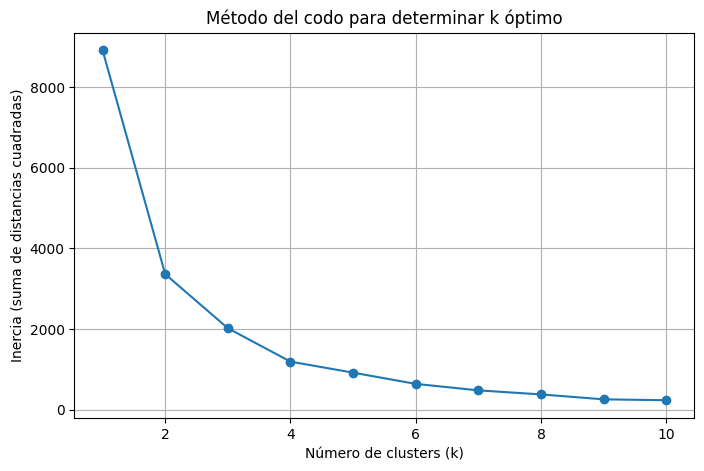

In [13]:
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(ciudades[['latitud', 'longitud']])
    inertias.append(kmeans.inertia_)

# Graficar el resultado
plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (suma de distancias cuadradas)')
plt.title('Método del codo para determinar k óptimo')
plt.grid(True)
plt.show()

A partir del grafico, se puede apreciar que el optimo es con 4, ya que despues de ese número deja de cambiar tan drasticamente

##### Grafico de las ciudades

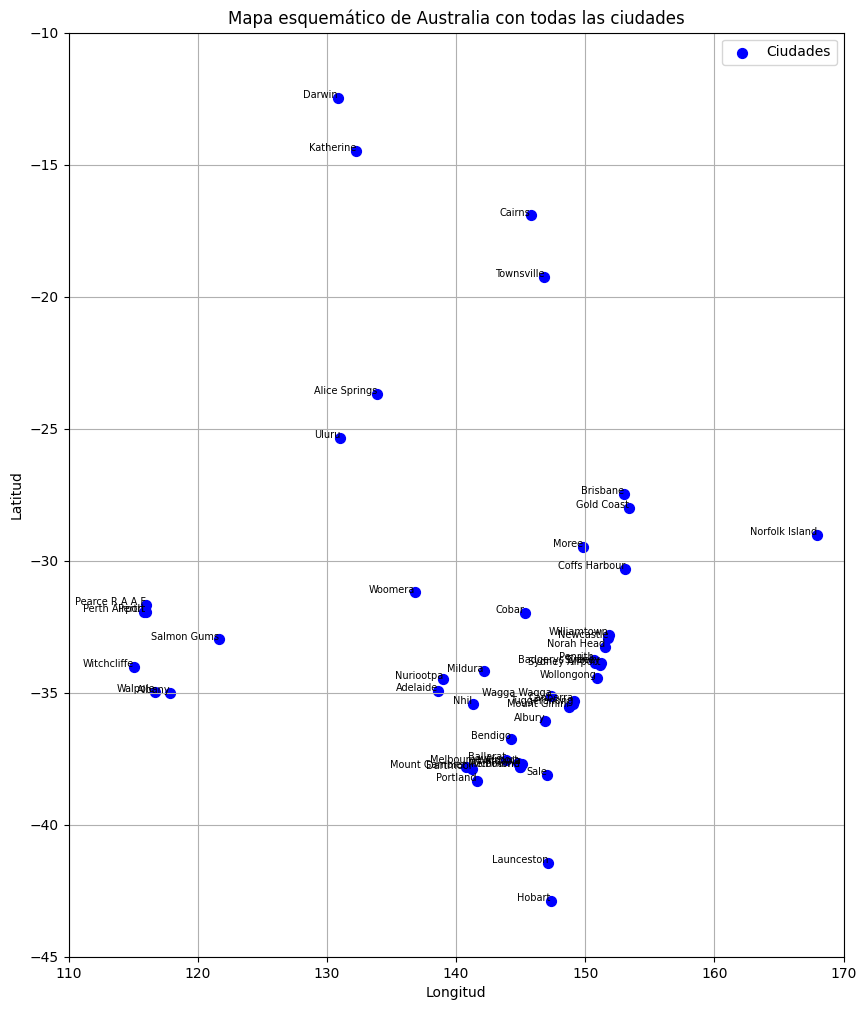

In [14]:
# Creamos un diccionario con la ciudad, y su longitud, para poder graficar.
city_coords = {item[0]: (item[1], item[2]) for item in ciudades.values}
plt.figure(figsize=(10, 12))
plt.scatter(
    [lon for lat, lon in city_coords.values()],
    [lat for lat, lon in city_coords.values()],
    s=50, c='blue', label='Ciudades'
)
for city, (lat, lon) in city_coords.items():
    plt.text(lon, lat, city, fontsize=7, ha='right')

plt.title('Mapa esquemático de Australia con todas las ciudades')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.xlim(110, 170)
plt.ylim(-45, -10)
plt.grid(True)
plt.legend()
plt.show()

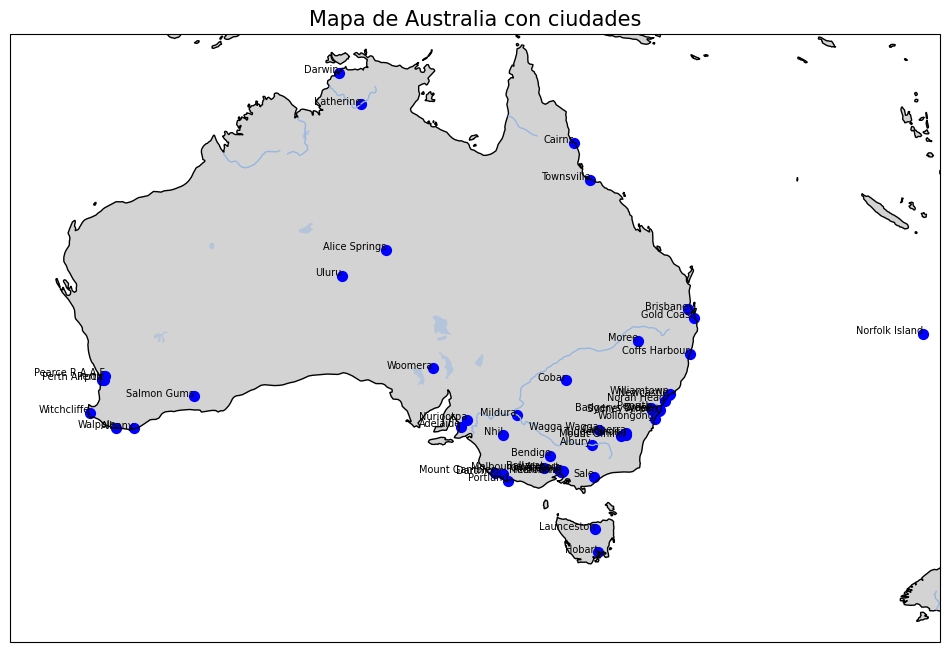

In [15]:
# Mapa hecho con cartopy
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())  # Proyección para coordenadas geográficas
ax.set_extent([110, 169, -45, -10])  # Limites del mapa (longitud mínima, máxima, latitud mínima, máxima)

# Agregar detalles al mapa
ax.add_feature(cfeature.LAND, facecolor='lightgrey')  # Color de la tierra
ax.add_feature(cfeature.COASTLINE)  # Costas
ax.add_feature(cfeature.BORDERS, linestyle=':')  # Fronteras
ax.add_feature(cfeature.LAKES, alpha=0.5)  # Lagos
ax.add_feature(cfeature.RIVERS)  # Ríos

for city, (lat, lon) in city_coords.items():
    plt.scatter(lon, lat, s=50, c='blue', label='Ciudades', transform=ccrs.PlateCarree())
    plt.text(lon, lat, city, fontsize=7, ha='right', transform=ccrs.PlateCarree())

plt.title('Mapa de Australia con ciudades', fontsize=15)
plt.show()

##### Agrupamos por ciudades

In [16]:
k_optimo = 4 # segun el grafico del codo

nombres_regiones = {
    0: 'Norte',
    1: 'Sur',
    2: 'Este',
    3: 'Oeste'
}

kmeans = KMeans(n_clusters=k_optimo, random_state=0)
ciudades['Region'] = kmeans.fit_predict(ciudades[['latitud', 'longitud']])

pronostico['Location'] = pronostico['Location'].apply(lambda x: formatear_ciudad(x))
pronostico = pronostico.merge(ciudades[['ciudad', 'Region']], left_on='Location', right_on='ciudad', how='left')
pronostico.drop(columns=['ciudad'], inplace=True)
pronostico['Region'] = pronostico['Region'].map(nombres_regiones)

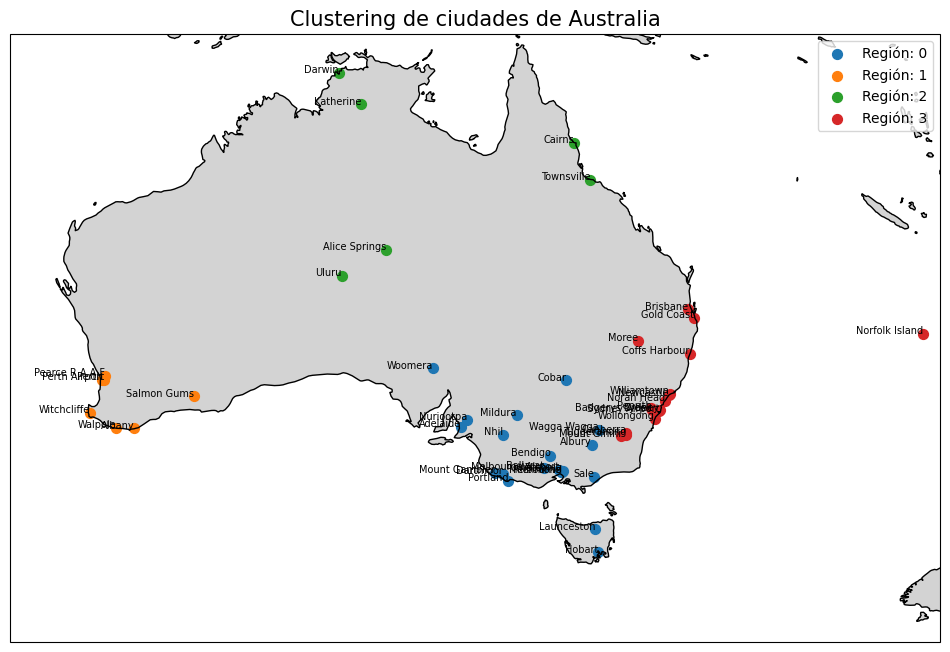

In [17]:
# Configuración del mapa
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([110, 169, -45, -10])  # Extensión del mapa (longitudes y latitudes de Australia)

# Agregar características al mapa
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Graficar las ciudades según la región
for region_name, region_id in nombres_regiones.items():
    region_data = ciudades[ciudades['Region'] == region_name]
    plt.scatter(
        region_data['longitud'],
        region_data['latitud'],
        label=f'Región: {region_name}',
        s=50,
        transform=ccrs.PlateCarree()
    )

# Agregar etiquetas de las ciudades
for _, row in ciudades.iterrows():
    plt.text(
        row['longitud'],
        row['latitud'],
        row['ciudad'],
        fontsize=7,
        ha='right',
        transform=ccrs.PlateCarree()
    )

# Configuración del gráfico
plt.title('Clustering de ciudades de Australia', fontsize=15)
plt.legend()
plt.show()


In [18]:
# Verificamos que no haya nulos en la columna RainTomorrow.
print(f"{pronostico["RainTomorrow"].isna().sum()} nulos en nuestra columna objetivo")

#Eliminamos los nulos
pronostico = pronostico.dropna(subset=["RainTomorrow"])

3267 nulos en nuestra columna objetivo


### Division del dataset

In [19]:
# Eliminamos las columnas Date y RainTomorrow, una es la que vamos a predecir y la otra es la no nos sirve para el modelo.
X = pronostico.drop(labels =['Date','RainTomorrow', 'Location', 'WindGustDir'], axis = 1)
y = pronostico['RainTomorrow']

In [20]:
# Ordenar los datos por fecha
pronostico = pronostico.sort_values(by='Date')

# Determinar el índice de corte para dividir en entrenamiento y prueba
train_size = int(len(pronostico) * 0.8)

# Dividir en conjuntos de entrenamiento y prueba
X_train = pronostico.iloc[:train_size].drop(['Date', 'RainTomorrow'], axis=1)
y_train = pronostico.iloc[:train_size]['RainTomorrow']

X_test = pronostico.iloc[train_size:].drop(['Date', 'RainTomorrow'], axis=1)
y_test = pronostico.iloc[train_size:]['RainTomorrow']

### Valores nulos

In [21]:
def rellenar_nulos_numericos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rellena los valores nulos numericos del dataframe con la mediana de la columna, por mes y región.
    Args:
        df (pd.DataFrame): DataFrame con los datos meteorológicos.
    Returns:
        pd.DataFrame: DataFrame con los valores nulos rellenados.
    """

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        # Rellenar los valores nulos con la mediana de la columna
        df[col] = df.groupby(['Estacion', 'Region'])[col].transform(lambda x: x.fillna(x.median()))

    return df

In [22]:
def rellenar_nulos_categoricos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rellena los valores nulos categoricos del dataframe con la moda de la columna, por mes y por region.
    Args:
        df (pd.DataFrame): DataFrame con los datos meteorológicos.
    Returns:
        pd.DataFrame: DataFrame con los valores nulos rellenados.
    """
    for col in df.select_dtypes(include=['object', 'category']).columns:
        def fill_mode(x):
            modes = x.mode()
            if len(modes) > 0:
                return x.fillna(modes[0])
            else:
                return x.fillna(method='ffill').fillna(method='bfill')  # alternativa si no hay modo
        
        df[col] = df.groupby(['Estacion', 'Region'])[col].transform(fill_mode)
    
    return df

In [23]:
X_train.isna().sum()

Location                0
MinTemp               469
MaxTemp               223
Rainfall             1128
Evaporation         44361
Sunshine            48542
WindGustDir          7735
WindGustSpeed        7675
WindDir9am              0
WindDir3pm              0
WindSpeed9am         1203
WindSpeed3pm         1400
Humidity9am          1476
Humidity3pm          1695
Pressure9am         11069
Pressure3pm         11034
Cloud9am            41346
Cloud3pm            42639
Temp9am               807
Temp3pm               986
RainToday            1128
dia                     0
mes                     0
año                     0
Estacion                0
Direccion_viento        0
Tipo_lluvia             0
Region                  0
dtype: int64

In [24]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,dia,mes,año
count,113285.000000,113531.000000,112626.000000,69393.000000,65212.000000,106079.000000,112551.000000,112354.000000,112278.000000,112059.000000,102685.000000,102720.000000,72408.000000,71115.000000,112947.000000,112768.000000,113754.000000,113754.000000,113754.000000
mean,11.951064,22.959709,2.345608,5.301313,7.588464,40.063641,14.032714,18.685921,68.815271,51.532380,1017.801118,1015.409600,4.330654,4.430106,16.762038,21.479511,15.702815,6.492985,2011.895889
std,6.371251,7.033272,8.491865,3.989902,3.772434,13.623196,8.957718,8.854735,19.048500,20.729464,7.133546,7.061167,2.877291,2.704055,6.440774,6.873108,8.819406,3.377355,2.064803
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-6.200000,-5.100000,1.000000,1.000000,2007.000000
25%,7.400000,17.800000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.100000,1010.600000,1.000000,2.000000,12.100000,16.500000,8.000000,4.000000,2010.000000
50%,11.800000,22.300000,0.000000,4.600000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.800000,1015.400000,5.000000,5.000000,16.500000,20.900000,16.000000,7.000000,2012.000000
75%,16.600000,27.900000,0.800000,7.200000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.600000,1020.200000,7.000000,7.000000,21.300000,26.100000,23.000000,9.000000,2014.000000
max,33.900000,48.100000,371.000000,82.400000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.100000,31.000000,12.000000,2015.000000


In [25]:
X_train = rellenar_nulos_numericos(X_train) # Rellenamos los nulos numricos
X_train = rellenar_nulos_categoricos(X_train) # Rellenamos los nulos categoricos

X_test = rellenar_nulos_numericos(X_test) # Rellenamos los nulos numricos
X_test = rellenar_nulos_categoricos(X_test) # Rellenamos los nulos categoricos

### Graficos

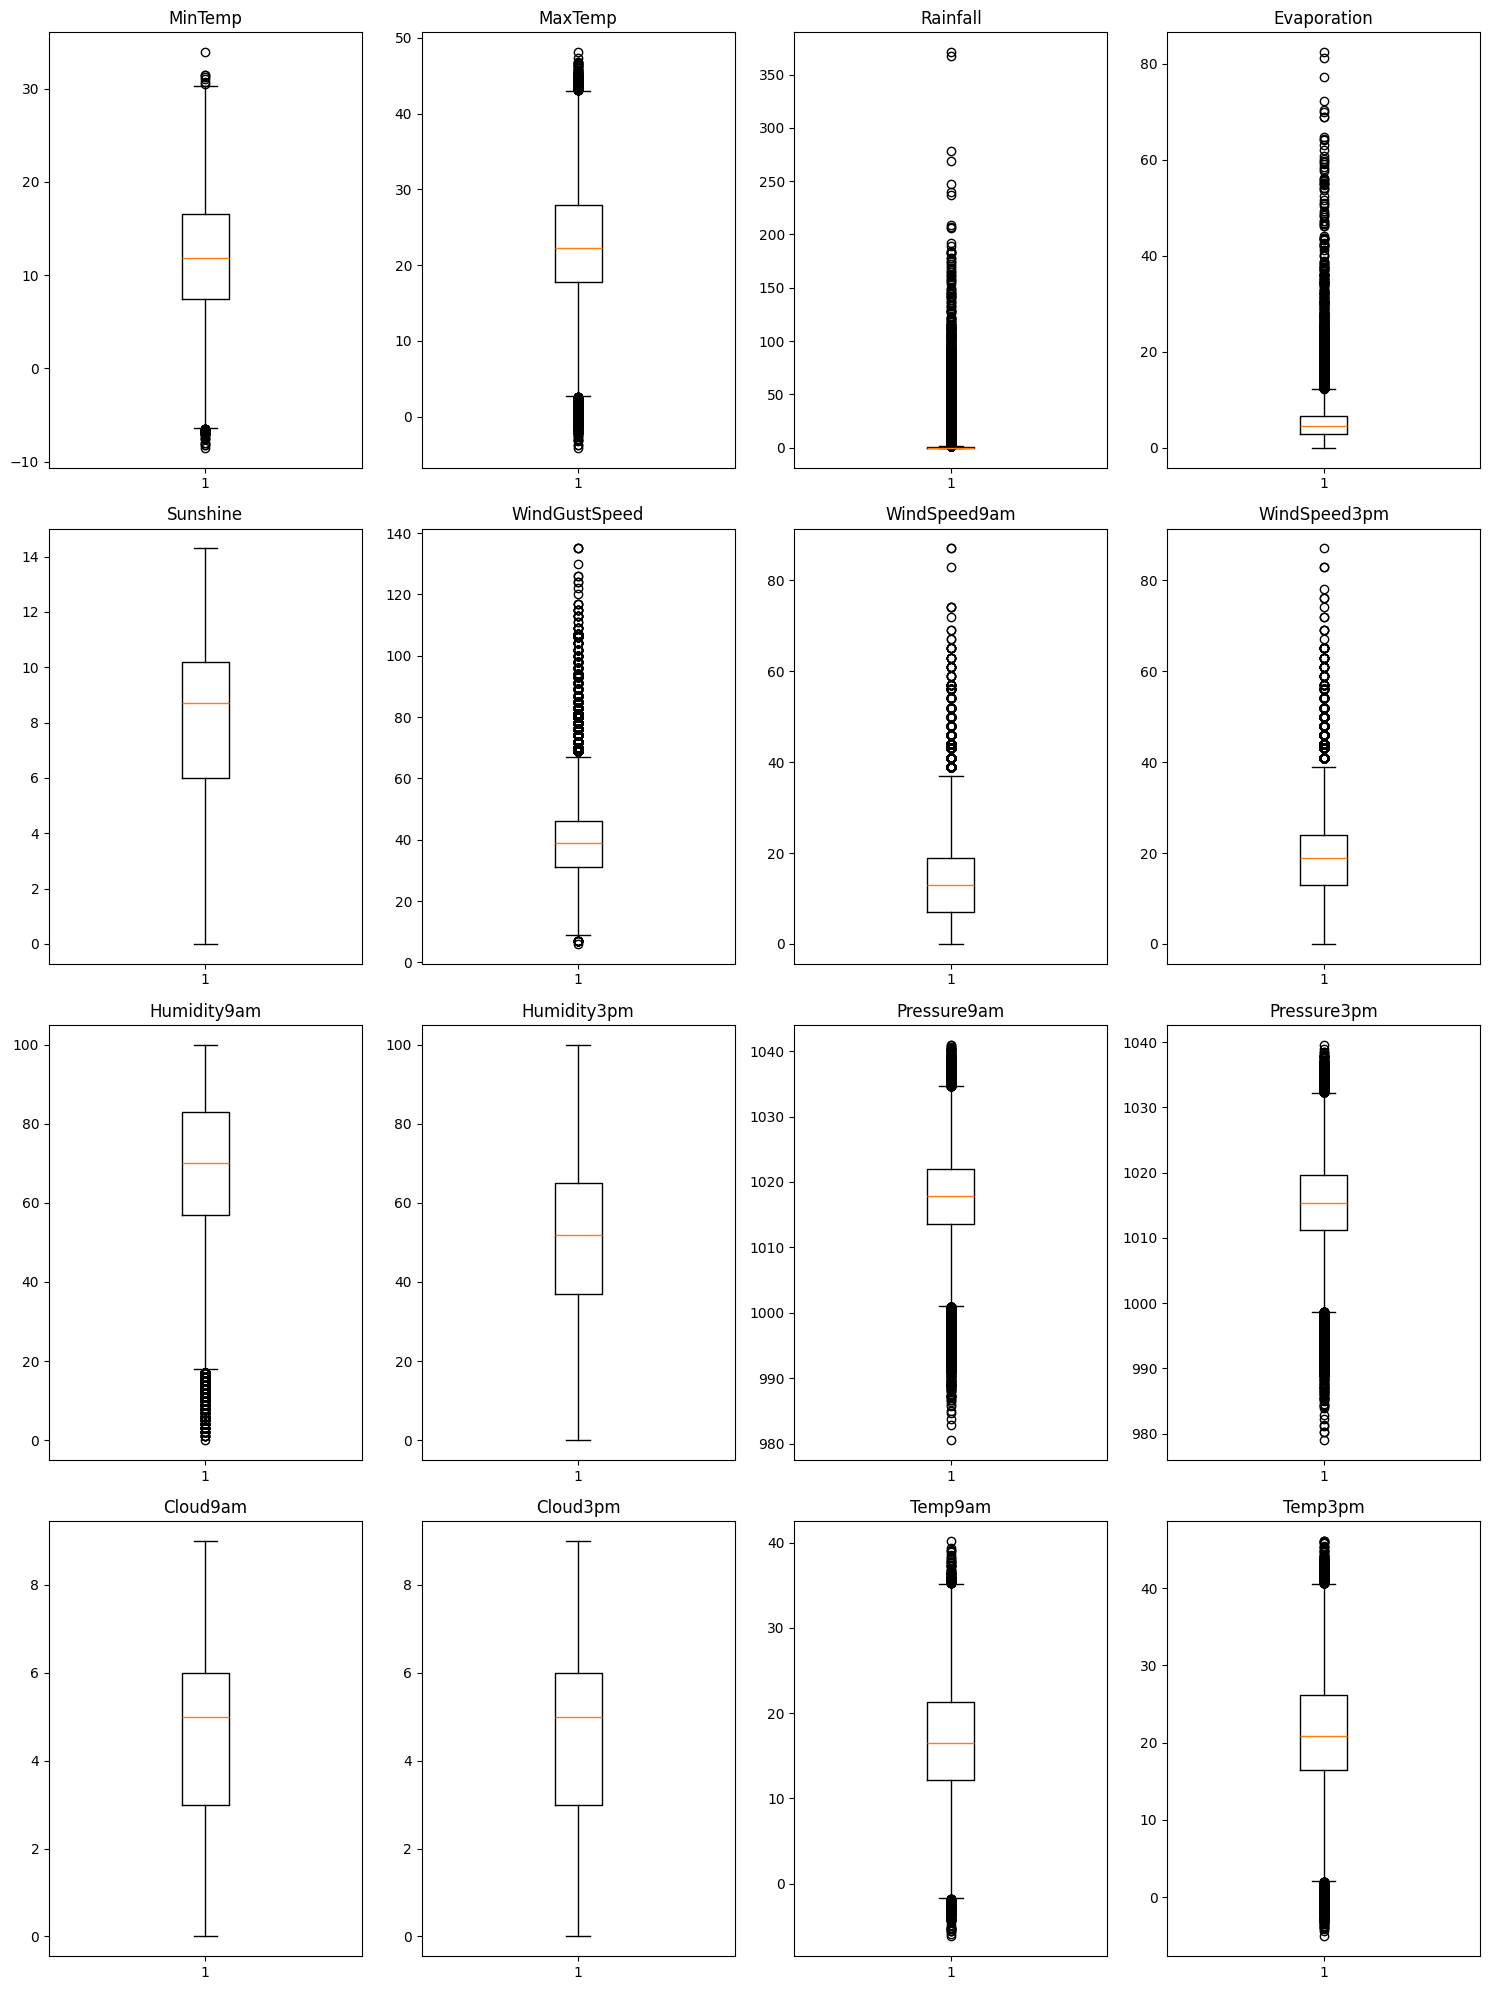

In [26]:
# Boxplots

# Obtenemos las columnas numericos
numericas = list(X_train.select_dtypes(include=['float64', 'int64']).columns)

# Graficamos los boxplot de las columnas numericas
fig, axis = plt.subplots(4, 4, figsize=(15, 20))

# Aplanamos la matriz de subgráficos para facilitar el acceso
axis = axis.flatten()

# Iteramos sobre las columnas numéricas y los subgráficos
for i, columans in enumerate(numericas):
    axis[i].boxplot(X_train[columans])
    axis[i].set_title(columans)

plt.tight_layout()
plt.show()

Se pueden apreciar presencia de valores atipico, pero la mayoria de ellos seria de cuando llueve, y/o relacionadas a otras variables que podrian explicarse. Variables como Evaporation o Rainfall, aparecen que tienen muchisimo valores atipico, pero se pueden explicarse debido a que no siempre llovia.

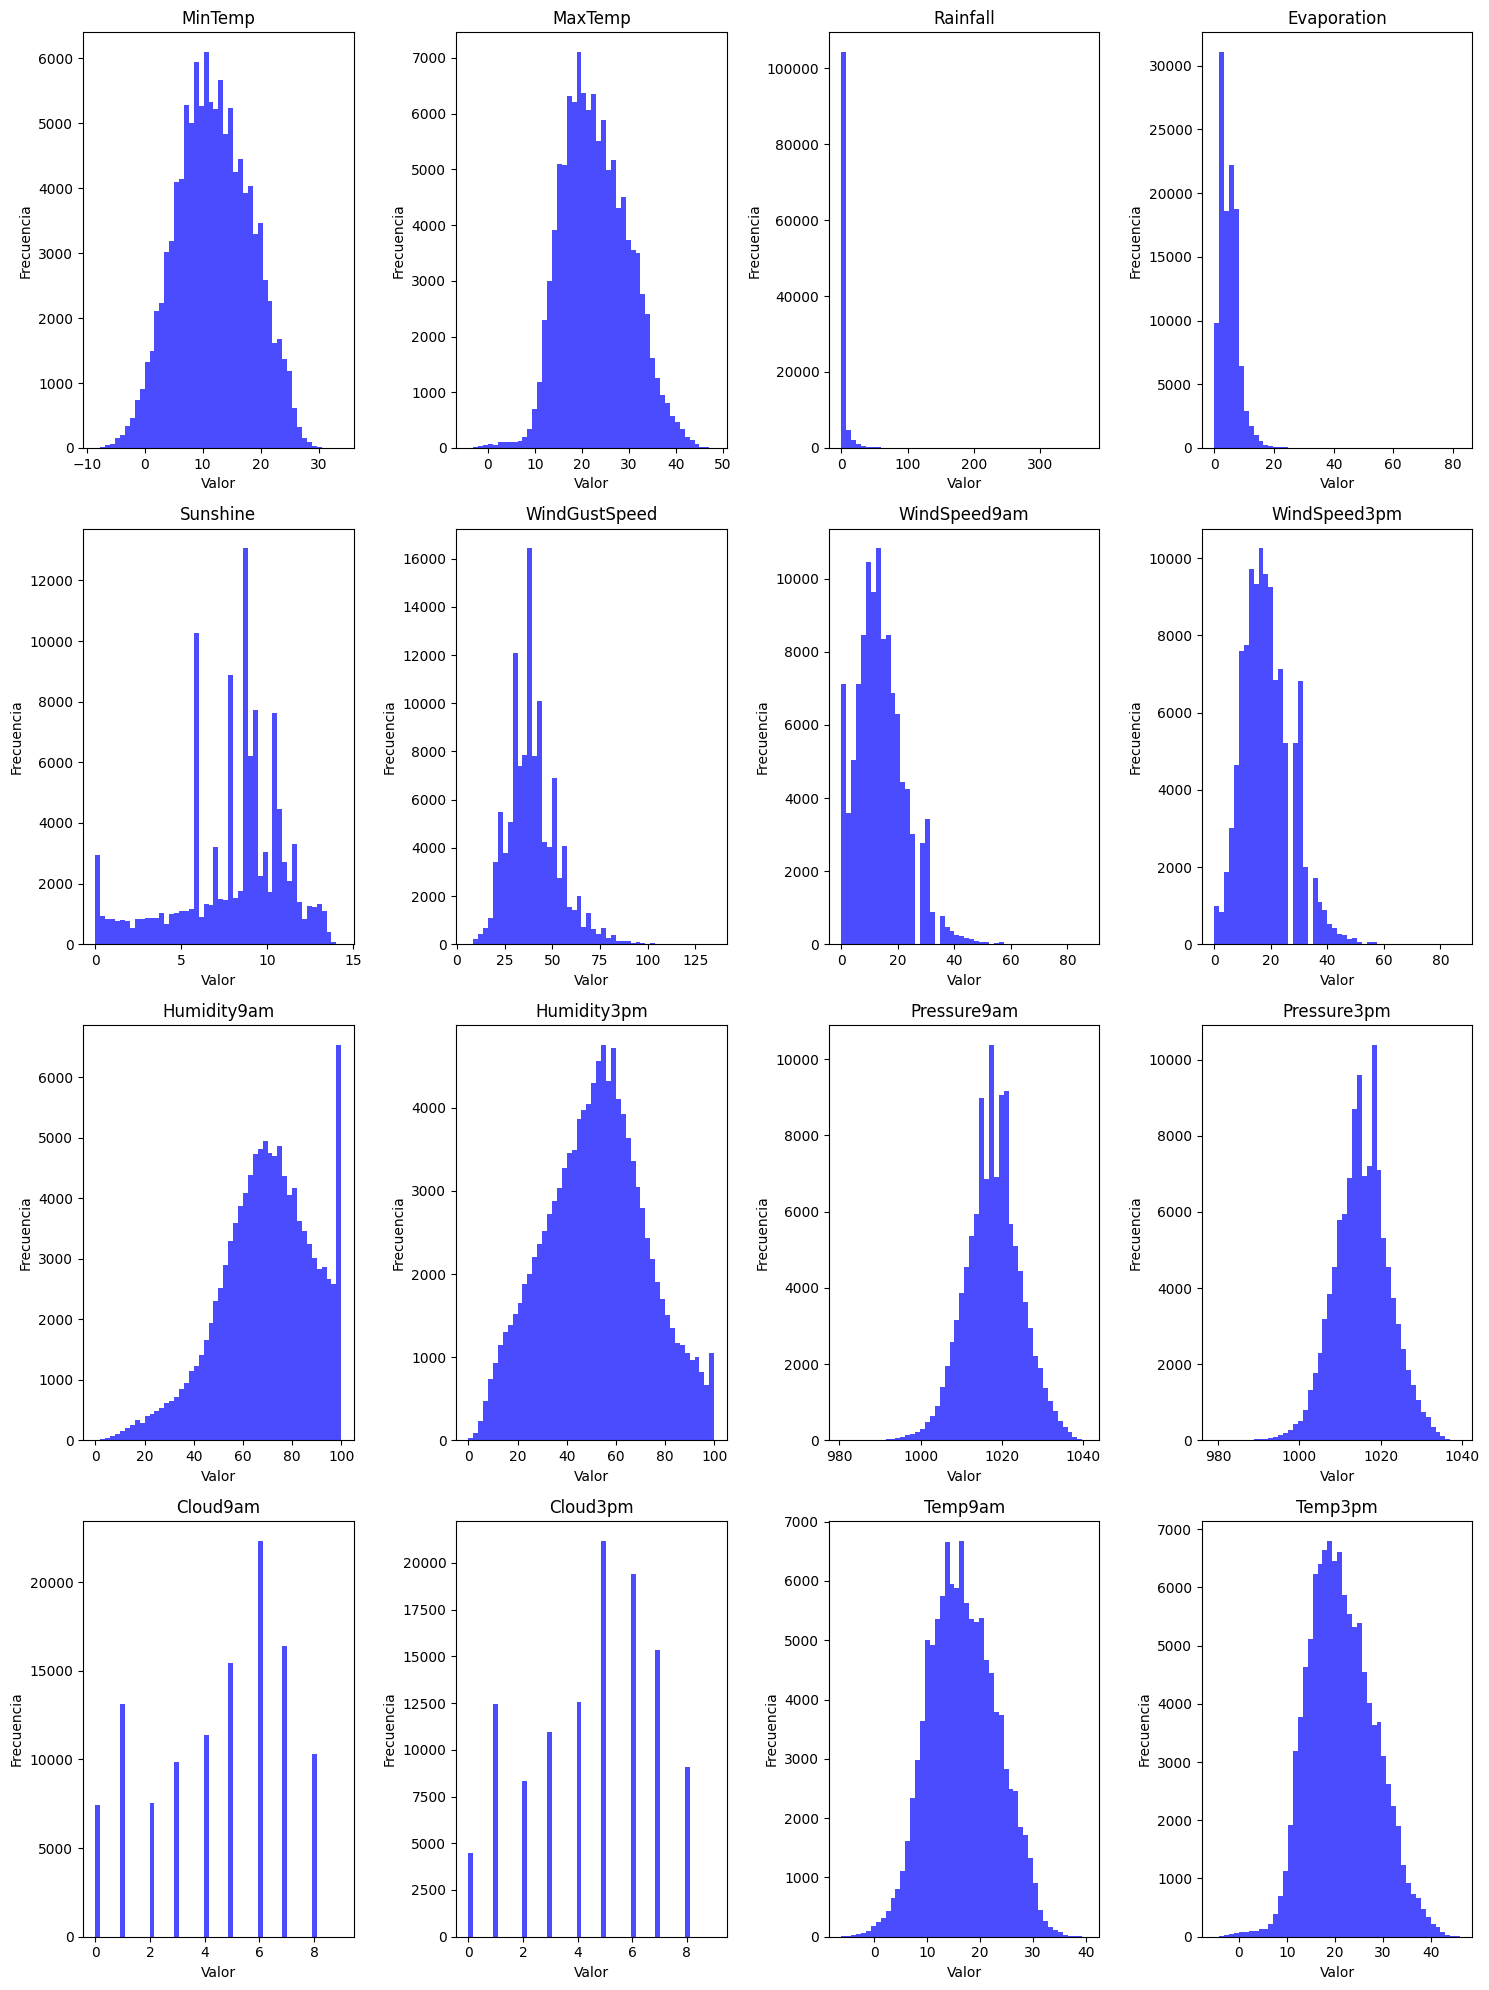

In [27]:
# Histogramas

fig, axis = plt.subplots(4, 4, figsize=(15, 20))

# Aplanamos la matriz de subgráficos para facilitar el acceso
axis = axis.flatten()

# Iteramos sobre las columnas numéricas y los subgráficos

for i, columans in enumerate(numericas):
    axis[i].hist(X_train[columans], bins=50, color='blue', alpha=0.7)
    axis[i].set_title(columans)
    axis[i].set_xlabel('Valor')
    axis[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

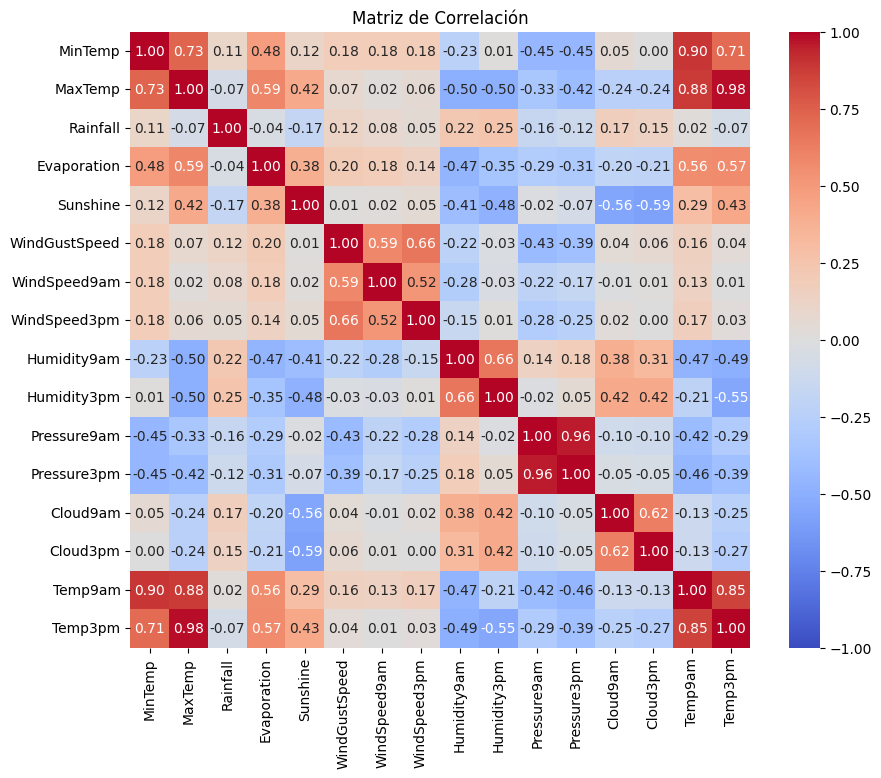

In [28]:
# Matriz de correlación

correlacion = X_train[numericas].corr()

# Visualizamos la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

In [29]:
# Verificamos si la variable target está balanceada
no, si = y_train.value_counts()
total = no + si
print(f"Porcentaje de lluvia: {si/total*100:.2f}%")

Porcentaje de lluvia: 22.44%


Se puede apreciar que se encuentra desbalanciado, con un 22.45% de valores que predicen que va a llover

### Estandarización

In [30]:
# Estandarización de variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numericas])
X_test_scaled = scaler.transform(X_test[numericas])

# Codificación de variables categóricas
variables_categoricas = ['Estacion', 'Direccion_viento', 'Tipo_lluvia', 'Region', 'RainToday', 'WindDir9am', 'WindDir3pm']
X_train_cat = pd.get_dummies(X_train[variables_categoricas], drop_first=False)
X_test_cat = pd.get_dummies(X_test[variables_categoricas], drop_first=False)

# Aseguramos que las columnas sean consistentes
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='outer', axis=1, fill_value=0)

# Convertimos los datos escalados en DataFrames para mantener consistencia con los nombres de columnas
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numericas, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numericas, index=X_test.index)

# Combinación final
X_train_final = pd.concat([X_train_scaled_df, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_cat], axis=1)


### Entrenamiento del modelo y métricas

In [36]:
# Entrenamos el modelo
modelo = LogisticRegression(random_state=42, max_iter=500)
modelo.fit(X_train_final, y_train)

LogisticRegression(max_iter=500, random_state=42)

#### Predicción y matríz de confusión con X_train

Accuracy: 0.85
Precision: 0.72
Recall: 0.51
F1 Score: 0.60


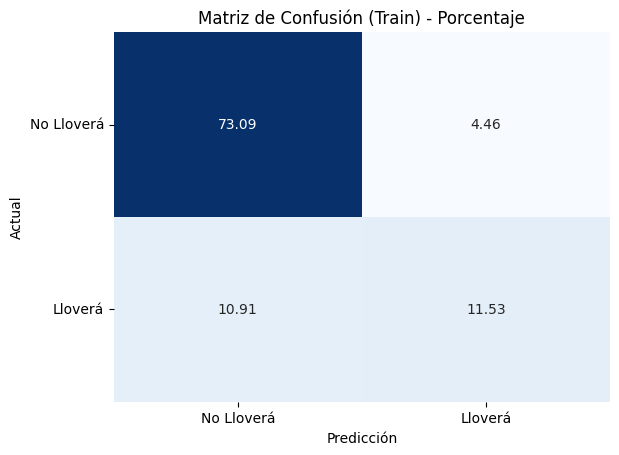

In [ ]:
# Generar predicciones para el conjunto de entrenamiento
y_train_pred = modelo.predict(X_train_final)

# Métricas básicas
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, pos_label='Yes')
recall = recall_score(y_train, y_train_pred, pos_label='Yes')
f1 = f1_score(y_train, y_train_pred, pos_label='Yes')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Crear la matriz de confusión
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Convertir los valores en porcentaje
conf_matrix_train_percent = conf_matrix_train / conf_matrix_train.sum() * 100

# Visualizar la matriz de confusión
plt.figure()
sns.heatmap(conf_matrix_train_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión (Train) - Porcentaje")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()


#### Predicción y matríz de confusión con X_test

Accuracy: 0.84
Precision: 0.72
Recall: 0.48
F1 Score: 0.58


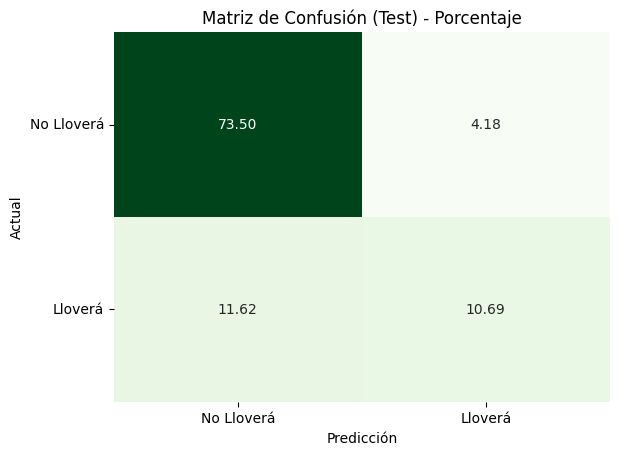

In [38]:
# Predicciones
y_pred = modelo.predict(X_test_final)
y_pred_proba = modelo.predict_proba(X_test_final)[:, 1]

# Métricas básicas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Matriz de confusión
conf_matrix_test = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
conf_matrix_test_percent = conf_matrix_test / conf_matrix_test.sum() * 100
sns.heatmap(conf_matrix_test_percent, annot=True, fmt=".2f", cmap="Greens", cbar=False)
plt.title("Matriz de Confusión (Test) - Porcentaje")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()

#### Analisis de falsos positivos y falsos negativos

Falsos Positivos (4.18%) -> Predicción incorrecta de "Lloverá" cuando realmente "No Lloverá"
Si el costo de emitir una alerta falsa es bajo, este nivel de falsos positivos podría ser aceptable.

Falsos Negativos (11.62%) -> Predicción incorrecta de "No Lloverá" cuando realmente "Lloverá".
No tomar precauciones cuando llueve podría tener un impacto mayor, como daños materiales, cancelación de eventos o riesgos para la población.
Este porcentaje es más crítico, especialmente si las lluvias severas son importantes de predecir en el contexto.

#### Curva ROC

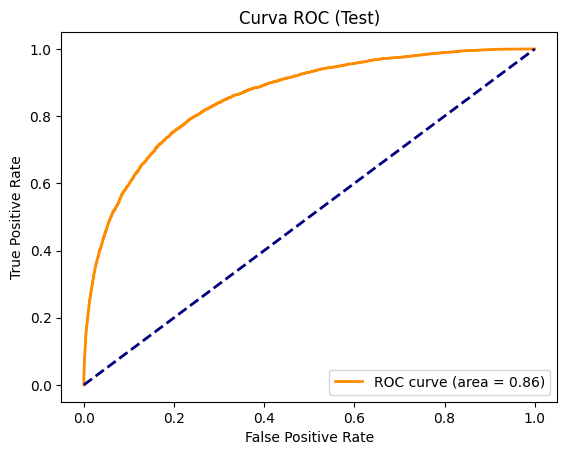

AUC: 0.86
Umbral óptimo: 0.19


In [40]:
# Generar probabilidades de predicción
y_pred_proba_test = modelo.predict_proba(X_test_final)[:, 1]

# Curva ROC para el conjunto de prueba
fpr, tpr, thresholds = roc_curve(y_test.map({'No': 0, 'Yes': 1}), y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (Test)')
plt.legend(loc="lower right")
plt.show()

# Identificar el umbral óptimo (maximizar TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"AUC: {roc_auc:.2f}")
print(f"Umbral óptimo: {optimal_threshold:.2f}")


#### Predicción y matríz de confusión con X_test con UMBRAL ÓPTIMO

Accuracy (umbral óptimo): 0.77
Precision (umbral óptimo): 0.49
Recall (umbral óptimo): 0.79
F1 Score (umbral óptimo): 0.61


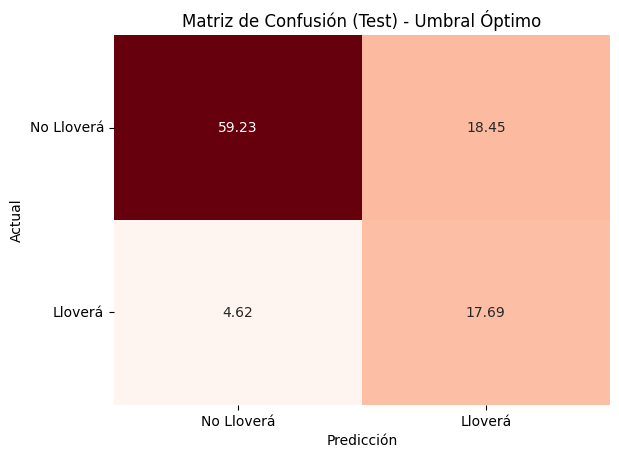

In [ ]:
# Usar el umbral óptimo para clasificar
y_pred_optimo = (y_pred_proba_test >= optimal_threshold).astype(int)

# Recalcular métricas con el nuevo umbral
accuracy_opt = accuracy_score(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo)
precision_opt = precision_score(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo)
recall_opt = recall_score(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo)
f1_opt = f1_score(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo)

print(f"Accuracy (umbral óptimo): {accuracy_opt:.2f}")
print(f"Precision (umbral óptimo): {precision_opt:.2f}")
print(f"Recall (umbral óptimo): {recall_opt:.2f}")
print(f"F1 Score (umbral óptimo): {f1_opt:.2f}")

# Calcular la matriz de confusión
conf_matrix_opt = confusion_matrix(y_test.map({'No': 0, 'Yes': 1}), y_pred_optimo)

# Convertir la matriz de confusión a porcentajes
conf_matrix_opt_percent = conf_matrix_opt / conf_matrix_opt.sum() * 100

# Graficar la matriz de confusión
plt.figure()
sns.heatmap(conf_matrix_opt_percent, annot=True, fmt=".2f", cmap="Reds", cbar=False)
plt.title("Matriz de Confusión (Test) - Umbral Óptimo")
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Lloverá', 'Lloverá'], rotation=0)
plt.show()

    Los falsos negativos se redujeron significativamente...

* El porcentaje de falsos negativos (casos donde predecimos "No Lloverá" y en realidad sí llovió) bajó de 11.62% a 4.62%. Esto es una mejora importante, especialmente en un contexto donde predecir lluvia erróneamente como ausencia podría tener consecuencias críticas.

* A costa de mejorar la cantidad de falsos negativos, el porcentaje de falsos positivos (predicciones de "Lloverá" cuando realmente no llovió) subió de 4.18% a 18.45%. Este incremento puede ser tolerable dependiendo del contexto del problema, pero es un costo a considerar si las falsas alarmas tienen impacto negativo.